## Import package

In [2]:
import numpy as np
import random
import os
import cv2
import torch
import ast
import csv
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    Resize,
    RandomRotation,
    ToPILImage,
    ToTensor,
    CenterCrop,
)
from sklearn.svm import SVC
from torchsummary import summary
from transformers import ConvNextFeatureExtractor
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score,roc_auc_score

## Algorithm for calculating IOU
- reference: https://gist.github.com/AruniRC/c629c2df0e68e23aff7dcaeef87c72d4

In [3]:
from __future__ import division
import scipy.optimize

def bbox_iou(boxA, boxB):
  # https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
  # ^^ corrected.
    
  # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = xB - xA + 1
    interH = yB - yA + 1

  # Correction: reject non-overlapping boxes
    if interW <=0 or interH <=0 :
        return -1.0

    interArea = interW * interH
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou



def match_bboxes(bbox_gt, bbox_pred, IOU_THRESH=0.1):
    '''
    Given sets of true and predicted bounding-boxes,
    determine the best possible match.
    Parameters
    ----------
    bbox_gt, bbox_pred : N1x4 and N2x4 np array of bboxes [x1,y1,x2,y2]. 
      The number of bboxes, N1 and N2, need not be the same.
    
    Returns
    -------
    (idxs_true, idxs_pred, ious, labels)
        idxs_true, idxs_pred : indices into gt and pred for matches
        ious : corresponding IOU value of each match
        labels: vector of 0/1 values for the list of detections
    '''
    n_true = bbox_gt.shape[0]
    n_pred = bbox_pred.shape[0]
    MAX_DIST = 1.0
    MIN_IOU = 0.0

    # NUM_GT x NUM_PRED
    iou_matrix = np.zeros((n_true, n_pred))
    for i in range(n_true):
        for j in range(n_pred):
            iou_matrix[i, j] = bbox_iou(bbox_gt[i,:], bbox_pred[j,:])

    if n_pred > n_true:
      # there are more predictions than ground-truth - add dummy rows
        diff = n_pred - n_true
        iou_matrix = np.concatenate( (iou_matrix, 
                                    np.full((diff, n_pred), MIN_IOU)), 
                                  axis=0)

    if n_true > n_pred:
      # more ground-truth than predictions - add dummy columns
        diff = n_true - n_pred
        iou_matrix = np.concatenate( (iou_matrix, 
                                    np.full((n_true, diff), MIN_IOU)), 
                                  axis=1)

    # call the Hungarian matching
    idxs_true, idxs_pred = scipy.optimize.linear_sum_assignment(1 - iou_matrix)

    if (not idxs_true.size) or (not idxs_pred.size):
        ious = np.array([])
    else:
        ious = iou_matrix[idxs_true, idxs_pred]

    # remove dummy assignments
    sel_pred = idxs_pred<n_pred
    idx_pred_actual = idxs_pred[sel_pred] 
    idx_gt_actual = idxs_true[sel_pred]
    ious_actual = iou_matrix[idx_gt_actual, idx_pred_actual]
    sel_valid = (ious_actual > IOU_THRESH)
    label = sel_valid.astype(int)

    return idx_gt_actual[sel_valid], idx_pred_actual[sel_valid], ious_actual[sel_valid], label 

## Using the csv file output from YOLO to get ROI image of mammogram
 - **predict_path** is the csv file path output from YOLO
 - **mass_path** is the path containing all mammogram images of EMBED

In [4]:
####################################################
#       Create Train, Valid and Test sets
####################################################
mass_path = "D:\\ml\\image\\png\\clean\\"
predict_path = os.path.join("D:","ml","CNN_labels_005_exp49.csv")
# predict_path = os.path.join("D:","ml","CNN_labels_train")
predict_csv = pd.read_csv(predict_path, dtype=str)
mass_image = []
no_mass_image = []
ground_name = []
ground_bbox = []
predict_bbox = []
predict_name = []
predict_conf = []
pred_area = []
pred_aspect = []
ground_area = []
ground_aspect = []
random.seed(42)
train_num = 5000
cnt = 0

with open("new_table.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        filename = row[0]
        result_list = ast.literal_eval(row[1])
        ground = []
        for i,ROI in enumerate(result_list):
            x1,y1,x2,y2 = ROI
            ground.append((x1,y1,x2,y2))
            ground_area.append((y2-y1)*(x2-x1))
            ground_aspect.append((y2-y1)/(x2-x1))
        ground_bbox.append(ground)
        ground_name.append(filename)

def find_value_index(lst, value):
    try:
        index = lst.index(value)
        return index
    except ValueError:
        return -1
    
for i,row in enumerate(predict_csv.iloc):
    box = []
    conf_list = []
    for roi in ast.literal_eval(row["ROI"]):
        y1,x1,y2,x2,conf = float(roi[0]),float(roi[1]),float(roi[2]),float(roi[3]),float(roi[4])
        box.append((int(x1),int(y1),int(x2),int(y2)))
        conf_list.append(conf)
    predict_bbox.append(box)
    predict_name.append(row['name'])
    predict_conf.append(conf_list)

pair = []            
no_mass_conf = []
mass_conf = []
for i,box_list in enumerate(predict_bbox):
    if predict_name[i]+".png" in ground_name:
        index = ground_name.index(predict_name[i]+".png")
        gd_box = ground_bbox[index]
        gd_index, pred_index, iou, label = match_bboxes(np.array(gd_box),np.array(box_list),0.00001)
        for a,index in enumerate(gd_index):
            pair.append((mass_path+predict_name[i]+".png",gd_box[gd_index[a]],box_list[pred_index[a]],iou[a]))
#         for j,l in enumerate(gd_box):
#             mass_image.append((mass_path+predict_name[i]+".png",l))
        for j,l in enumerate(label):
            if j not in pred_index:
                x1,y1,x2,y2 = box_list[j]
                no_mass_image.append((mass_path+predict_name[i]+".png",box_list[j],predict_conf[i][j]))
                no_mass_conf.append(predict_conf[i][j])
            if j in pred_index:
                iou_idx = np.where(pred_index == j)[0]
                if iou[iou_idx] > 0.1:
                    x1,y1,x2,y2 = box_list[j]
                    mass_image.append((mass_path+predict_name[i]+".png",box_list[j],predict_conf[i][j]))
                    mass_conf.append(predict_conf[i][j])
#         for i in range(len(gd_box)):
#             if i not in gd_index:
#                 mass_image.append((mass_path+predict_name[i]+".png",gd_box[i],0))
no_mass_image_train = no_mass_image[:3329]
# no_mass_image_train = no_mass_image[:4747]
print(len(no_mass_image_train))
print(len(mass_image))

3329
3329


### Confidence score distribution for detected mass and background

In [4]:
print(np.mean(mass_conf),np.std(mass_conf))
print(np.mean(no_mass_conf),np.std(no_mass_conf))
print(min(mass_conf))

0.16279181754280567 0.1100748650222076
0.10978603268349364 0.07313552577388312
0.0500488


### IOU threshold visualization to pick the best threshold

D:\ml\image\png\clean\1.2.826.0.1.3680043.8.498.14979660527156392366893948982475165724.dcm.png
D:\ml\image\png\clean\1.2.826.0.1.3680043.8.498.61921942335118913195519593404453034962.dcm.png
D:\ml\image\png\clean\1.2.826.0.1.3680043.8.498.66443671740990304997566684485192018207.dcm.png
D:\ml\image\png\clean\1.2.826.0.1.3680043.8.498.25173631433906458278103503214799076435.dcm.png
D:\ml\image\png\clean\1.2.826.0.1.3680043.8.498.20259570843897501476830433022472760457.dcm.png
D:\ml\image\png\clean\1.2.826.0.1.3680043.8.498.47873297232338691196823304516377128674.dcm.png
D:\ml\image\png\clean\1.2.826.0.1.3680043.8.498.90143587906887718146695598294882242011.dcm.png
D:\ml\image\png\clean\1.2.826.0.1.3680043.8.498.11869256838052254098631865139817543368.dcm.png
D:\ml\image\png\clean\1.2.826.0.1.3680043.8.498.69205496401226395947626693866073052090.dcm.png
D:\ml\image\png\clean\1.2.826.0.1.3680043.8.498.68063616626111800741051078175788944775.dcm.png


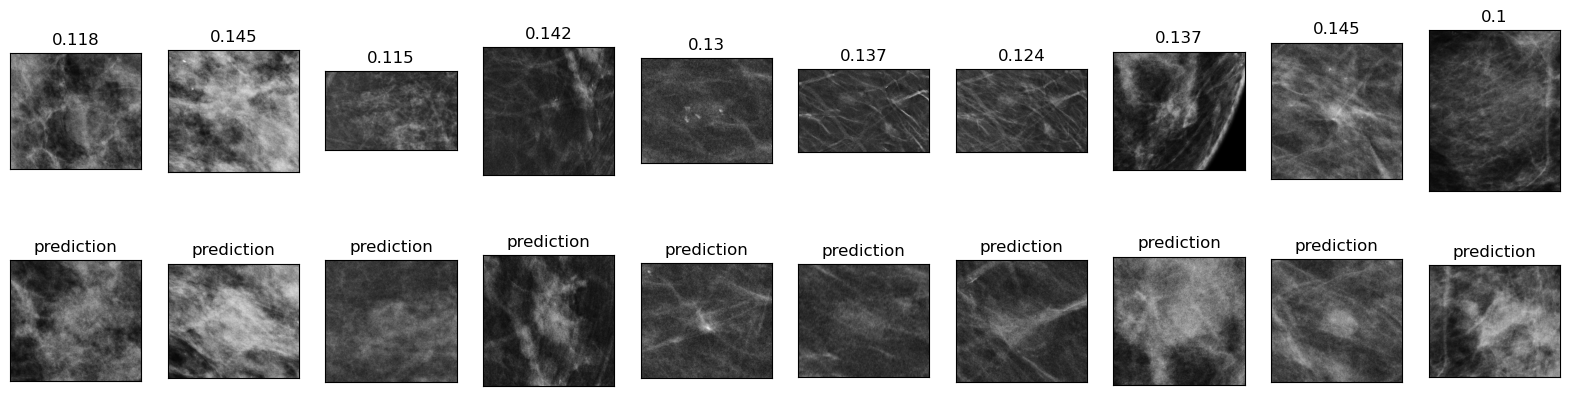

In [111]:
IOU_pair = [i for i, tup in enumerate(pair) if (tup[3] > 0.1 and tup[3] < 0.15)]
plt.figure(figsize=(20,5))
for i in range(10):
    j = i+20
    ax = plt.subplot(2, 10, i+1)
    image = cv2.imread(pair[IOU_pair[j]][0])
    x1,y1,x2,y2 = pair[IOU_pair[j]][1]
    plt.imshow(image[y1:y2,x1:x2],cmap="gray")
    plt.title(round(pair[IOU_pair[j]][3],3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#     plt.imshow(train_dataset[i][0].numpy().transpose((1,2,0))*255,cmap="gray")
    ax = plt.subplot(2, 10, i+11)
    x1,y1,x2,y2 = pair[IOU_pair[j]][2]
    plt.imshow(image[y1:y2,x1:x2],cmap="gray")
    plt.title("prediction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(pair[IOU_pair[j]][0])

## Train and validation split (80%,20%)

In [45]:
train_mass = mass_image[:int(0.8*len(mass_image))]
train_mass_conf = mass_conf[:int(0.8*len(mass_image))]
train_no_mass = no_mass_image_train[:int(0.8*len(no_mass_image_train))]
train_no_mass_conf = no_mass_conf[:int(0.8*len(no_mass_image_train))]
valid_mass = mass_image[int(0.8*len(mass_image)):]
valid_mass_conf = mass_conf[int(0.8*len(mass_image)):]
valid_no_mass = no_mass_image_train[int(0.8*len(no_mass_image_train)):]
valid_no_mass_conf = no_mass_conf[int(0.8*len(no_mass_image_train)):]

train_image = train_mass + train_no_mass
train_label = np.concatenate((np.ones(len(train_mass)), np.zeros(len(train_no_mass))))
train_conf = train_mass_conf + train_no_mass_conf
valid_image = valid_mass + valid_no_mass
valid_label = np.concatenate((np.ones(len(valid_mass)), np.zeros(len(valid_no_mass))))
valid_conf = valid_mass_conf + valid_no_mass_conf

combined_lists = list(zip(train_image, train_label,train_conf))
random.shuffle(combined_lists)
train_image, train_label,train_conf = zip(*combined_lists)
combined_lists = list(zip(valid_image, valid_label,valid_conf))
random.shuffle(combined_lists)
valid_image, valid_label,valid_conf = zip(*combined_lists)

print('train_image example: ', train_image[0])
print("Train:",len(train_image))
print(f"Background:{train_label.count(0)},Mass:{train_label.count(1)}")
print("Valid:",len(valid_image))
print(f"Background:{valid_label.count(0)},Mass:{valid_label.count(1)}")
# print(f"Test size: {len(test_image_paths)}")

train_image example:  ('D:\\ml\\image\\png\\clean\\1.2.826.0.1.3680043.8.498.11320306171816027783886254204012228429.dcm.png', (41, 2031, 346, 2374), 0.0561218)
Train: 5326
Background:2663,Mass:2663
Valid: 1332
Background:666,Mass:666


## Define and create the dataset

In [112]:
#######################################################
#               Define Dataset Class
#######################################################
normalize = Normalize(mean=[0.3117, 0.3117, 0.3117], std=[0.1215, 0.1215, 0.1215])
# normalize = Normalize(mean=[0.5060, 0.5060, 0.5060], std=[0.2982, 0.2982, 0.2982])
class2id = {"background":0,"mass":1}
id2class = {0:"background",1:"mass"}
def random_rotation_90_180_270(img):
    angle = torch.randint(0, 4, (1,)).item() * 90  # Randomly choose 0, 90, 180, or 270 degrees
    return transforms.functional.rotate(img, angle)

train_transform = Compose(
    [
        ToPILImage(),
        Resize((224,224)),
        RandomHorizontalFlip(0.5),
        random_rotation_90_180_270,
        ToTensor(),
        normalize,
    ]
)

test_transform = Compose(
    [
        ToPILImage(),
        Resize((224,224)),
        ToTensor(),
        normalize,
    ]
)
def preprocess(image):
    img = cv2.equalizeHist(image)
    gaussian_3 = cv2.GaussianBlur(img, (0, 0), 2.0)
    unsharp_image = cv2.addWeighted(img, 2.0, gaussian_3, -1.0, 0)
    median_image = cv2.medianBlur(unsharp_image, 3)
    color_image = cv2.merge([median_image] * 3)
    return color_image

class MassDataset(Dataset):
    def __init__(self, image,label,conf ,transform=False):
        self.label = label
        self.image = image
        self.conf = conf
        self.transform = transform
        
    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        x1,y1,x2,y2 = self.image[idx][1]
        im = cv2.imread(self.image[idx][0])[y1:y2, x1:x2]
        if self.transform:
            img = self.transform(im)
        return img, self.label[idx],idx,self.conf[idx]
#######################################################
#                  Create Dataset
#######################################################

train_dataset = MassDataset(train_image,train_label,train_conf,train_transform)
valid_dataset = MassDataset(valid_image,valid_label,valid_conf,test_transform) #test transforms are applied
# test_dataset = MassDataset(test_image,test_label,test_transform)

## Create dataloader

In [113]:

#######################################################
#                  Define Dataloaders
#######################################################
def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    index = [example[2] for example in examples]
    confidence = torch.tensor([example[3] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels, "index": index,"confidence":confidence}

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn
)
# test_loader = DataLoader(
#     test_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn
# )

### Calculate mean and std of ROI images here to normalize the image

In [250]:
mean = 0.
std = 0.
nb_samples = 0.
for data in train_loader:
    data = data["pixel_values"]
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples
for data in valid_loader:
    data = data["pixel_values"]
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
print(mean)
print(std)

KeyboardInterrupt: 

## Define model 
Below are all different models we have tried to train including:
- ConvNeXt-tiny
- ConvNeXt-small
- Resnet50
- InceptionV3
- ResNeXt50_32x4d

Transfer learning techniques are applied here to load the pretrained weights and freeze some layers

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')
print(device)

In [43]:
model = models.convnext_tiny(weights='IMAGENET1K_V1')
for i,para in enumerate(model.parameters()):
    para.requires_grad = False
for para in model.features[5:8].parameters():
    para.requires_grad = True
model.classifier[2] = nn.Linear(in_features=model.classifier[2].in_features,out_features=2,bias=True)
# model.classifier.append(nn.ReLU())
# model.classifier.append(nn.Dropout(0.2))
# model.classifier.append(nn.Linear(in_features=128,out_features=2,bias=True))
model = model.to(device)
summary(model,(3,224,224))
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,"min",factor = 0.5,patience=10,verbose=True)
criterion = nn.CrossEntropyLoss() 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

In [332]:
model = models.convnext_small(weights='IMAGENET1K_V1')
for i,para in enumerate(model.parameters()):
    para.requires_grad = False
for para in model.features[7].parameters():
    para.requires_grad = True
model.classifier[2] = nn.Linear(in_features=model.classifier[2].in_features,out_features=2,bias=True)
model = model.to(device)
summary(model,(3,224,224))
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,"min",factor = 0.5,patience=10,verbose=True)
criterion = nn.CrossEntropyLoss() 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

In [36]:
model = models.resnet50(weights='IMAGENET1K_V2')
# for i,para in enumerate(model.parameters()):
#     para.requires_grad = False
model.fc = nn.Linear(in_features=model.fc.in_features,out_features=2,bias=True)
model = model.to(device)
summary(model,(3,224,224))
optimizer = optim.Adam(model.parameters(),lr=5e-4)
criterion = nn.CrossEntropyLoss() 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,"min",factor = 0.5,patience=10,verbose=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [38]:
model = models.inception_v3(weights='IMAGENET1K_V1')
# for i,para in enumerate(model.parameters()):
#     para.requires_grad = False
# for para in model.Mixed_7c.branch_pool.parameters():
#     para.requires_grad = True
model.fc = nn.Linear(in_features=model.fc.in_features,out_features=2,bias=True)
model = model.to(device)
summary(model,(3,299,299))
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,"min",factor = 0.5,patience=10,verbose=True)
criterion = nn.CrossEntropyLoss() 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [39]:
model = models.resnext50_32x4d(weights='IMAGENET1K_V2')
model.fc = nn.Linear(in_features=model.fc.in_features,out_features=2,bias=True)
model = model.to(device)
summary(model,(3,224,224))
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss() 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,"min",factor = 0.5,patience=10,verbose=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Train the CNN model
- We use tensorboard here to monitor the training process
- In every epoch, training and validation accuracy and loss would be shown and write to the tensorboard
- Epoch with the lowest loss in the model would be saved at checkpoint_best variable to save the best model in training process
- After training, we run the below cell to save the best model 

In [44]:
writer = SummaryWriter("runs/convnext-tf3-newyolo")
LOSS = 100
for epoch in range(1000):
    model.train()
    print("Epoch:", epoch)
    train_loss = 0.0
    correct = 0
    for idx, batch in enumerate(tqdm(train_loader)):
        data = batch["pixel_values"].to(device)
        label = batch["labels"].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == label).sum()
        train_loss += loss.item()
        
    avgloss = train_loss / len(train_loader)
    acc = correct / len(train_loader.dataset)
    writer.add_scalar("training accuracy",acc,epoch)
    writer.add_scalar("training loss",avgloss,epoch)
    print("Training")
    print(f"  avg loss:{avgloss}\n    accuracy:{acc*100}")
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        correct = 0
        for idx, batch in enumerate(valid_loader):

            data = batch["pixel_values"].to(device)
            label = batch["labels"].type(torch.LongTensor).to(device)

            outputs = model(data)
            loss = criterion(outputs, label)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == label).sum()
            valid_loss += loss.item()
            
        acc = correct / len(valid_loader.dataset)
        avgloss = valid_loss / len(valid_loader)
        writer.add_scalar("validation accuracy",acc,epoch)
        writer.add_scalar("validation loss",avgloss,epoch)
        print("Validation")
        print(f"    accuracy:{acc*100}")
        print(f"  avg loss:{avgloss}\n    accuracy:{acc*100}")
        checkpoint = {
                "epoch":epoch,
                "model_state":model.state_dict(),
                "optim_state":optimizer.state_dict(),
                "scheduler_state":scheduler.state_dict(),
                "loss": avgloss
            }
        if avgloss < LOSS:
            checkpoint_best = {
                "epoch":epoch,
                "model_state":model.state_dict(),
                "optim_state":optimizer.state_dict(),
                "scheduler_state":scheduler.state_dict(),
                "loss": avgloss
            }
            LOSS = avgloss
    scheduler.step(avgloss)
writer.flush()
writer.close()

Epoch: 0


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.7142317536331358
    accuracy:50.26286315917969
Validation
    accuracy:52.02702713012695
  avg loss:0.6902700987729159
    accuracy:52.02702713012695
Epoch: 1


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6926989143803006
    accuracy:53.022911071777344
Validation
    accuracy:50.30030059814453
  avg loss:0.6910067254846747
    accuracy:50.30030059814453
Epoch: 2


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6847607039269947
    accuracy:56.0645866394043
Validation
    accuracy:53.978981018066406
  avg loss:0.6765031489458951
    accuracy:53.978981018066406
Epoch: 3


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6677312779994238
    accuracy:57.64175796508789
Validation
    accuracy:59.009010314941406
  avg loss:0.6610169031403281
    accuracy:59.009010314941406
Epoch: 4


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6490918809459323
    accuracy:61.885093688964844
Validation
    accuracy:61.486488342285156
  avg loss:0.6540156927975741
    accuracy:61.486488342285156
Epoch: 5


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6460125162487939
    accuracy:61.20915985107422
Validation
    accuracy:60.58558654785156
  avg loss:0.6536793871359392
    accuracy:60.58558654785156
Epoch: 6


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6378531200545174
    accuracy:62.48591613769531
Validation
    accuracy:59.909908294677734
  avg loss:0.6580916263840415
    accuracy:59.909908294677734
Epoch: 7


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6337427184695289
    accuracy:63.23695373535156
Validation
    accuracy:63.13813781738281
  avg loss:0.6454297791827809
    accuracy:63.13813781738281
Epoch: 8


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6295986814158303
    accuracy:62.598575592041016
Validation
    accuracy:61.93693923950195
  avg loss:0.6534934910860929
    accuracy:61.93693923950195
Epoch: 9


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.631220342147918
    accuracy:62.27938461303711
Validation
    accuracy:61.261260986328125
  avg loss:0.6596434116363525
    accuracy:61.261260986328125
Epoch: 10


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.625833429041363
    accuracy:62.598575592041016
Validation
    accuracy:62.08708953857422
  avg loss:0.6371491551399231
    accuracy:62.08708953857422
Epoch: 11


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6195025103432792
    accuracy:64.51371002197266
Validation
    accuracy:62.91291809082031
  avg loss:0.6485382860357111
    accuracy:62.91291809082031
Epoch: 12


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6122429910160246
    accuracy:65.17086029052734
Validation
    accuracy:64.41442108154297
  avg loss:0.6264668107032776
    accuracy:64.41442108154297
Epoch: 13


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6017748287745884
    accuracy:65.75291442871094
Validation
    accuracy:65.16516876220703
  avg loss:0.6298299594358965
    accuracy:65.16516876220703
Epoch: 14


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6058394923096612
    accuracy:66.07209777832031
Validation
    accuracy:65.69068908691406
  avg loss:0.6391895413398743
    accuracy:65.69068908691406
Epoch: 15


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5877322327523005
    accuracy:67.98723602294922
Validation
    accuracy:63.13813781738281
  avg loss:0.6358458237214522
    accuracy:63.13813781738281
Epoch: 16


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5802830571220035
    accuracy:68.77581787109375
Validation
    accuracy:60.960960388183594
  avg loss:0.6559058752926913
    accuracy:60.960960388183594
Epoch: 17


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5886699834040233
    accuracy:67.78070068359375
Validation
    accuracy:58.18318557739258
  avg loss:0.6552729281512174
    accuracy:58.18318557739258
Epoch: 18


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5746483497676396
    accuracy:68.6256103515625
Validation
    accuracy:66.89189147949219
  avg loss:0.6118178421800787
    accuracy:66.89189147949219
Epoch: 19


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5565477112929026
    accuracy:70.67217254638672
Validation
    accuracy:66.44143676757812
  avg loss:0.6329951394687999
    accuracy:66.44143676757812
Epoch: 20


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5499774316946665
    accuracy:71.2166748046875
Validation
    accuracy:66.96697235107422
  avg loss:0.610861371863972
    accuracy:66.96697235107422
Epoch: 21


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5472543480850401
    accuracy:71.44198608398438
Validation
    accuracy:65.7657699584961
  avg loss:0.6174688285047357
    accuracy:65.7657699584961
Epoch: 22


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5428917578288487
    accuracy:71.44198608398438
Validation
    accuracy:67.49250030517578
  avg loss:0.6022957021539862
    accuracy:67.49250030517578
Epoch: 23


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5143727880148661
    accuracy:74.40856170654297
Validation
    accuracy:68.31832122802734
  avg loss:0.5951827601952986
    accuracy:68.31832122802734
Epoch: 24


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5185148389566512
    accuracy:73.77017974853516
Validation
    accuracy:66.29129028320312
  avg loss:0.607007460160689
    accuracy:66.29129028320312
Epoch: 25


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5119337467920213
    accuracy:74.44611358642578
Validation
    accuracy:65.61561584472656
  avg loss:0.6110128353942524
    accuracy:65.61561584472656
Epoch: 26


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.505333539985475
    accuracy:74.40856170654297
Validation
    accuracy:67.11711883544922
  avg loss:0.5961046489802274
    accuracy:67.11711883544922
Epoch: 27


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.47650035931950524
    accuracy:76.90574645996094
Validation
    accuracy:67.94294738769531
  avg loss:0.6135484549132261
    accuracy:67.94294738769531
Epoch: 28


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.46715308512960163
    accuracy:78.31392669677734
Validation
    accuracy:65.54054260253906
  avg loss:0.6588953083211725
    accuracy:65.54054260253906
Epoch: 29


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.4956201272351401
    accuracy:75.55388641357422
Validation
    accuracy:68.16816711425781
  avg loss:0.6297982822765004
    accuracy:68.16816711425781
Epoch: 30


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.44594051724388484
    accuracy:78.95230865478516
Validation
    accuracy:67.34234619140625
  avg loss:0.6486419114199552
    accuracy:67.34234619140625
Epoch: 31


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.4307059943675995
    accuracy:80.078857421875
Validation
    accuracy:67.34234619140625
  avg loss:0.6481925682588057
    accuracy:67.34234619140625
Epoch: 32


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.415357496766817
    accuracy:80.90499877929688
Validation
    accuracy:65.9159164428711
  avg loss:0.6741019216450778
    accuracy:65.9159164428711
Epoch: 33


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.4060016338314329
    accuracy:81.20540618896484
Validation
    accuracy:65.16516876220703
  avg loss:0.6973312388766896
    accuracy:65.16516876220703
Epoch: 34


  0%|          | 0/42 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [46]:
torch.save(checkpoint_best,"./CNN_model/convnext_tf3_newyolo__checkpoint_best.pth")
# torch.save(checkpoint,"./CNN_model/resnext50_checkpoint.pth")

# Evaluate the CNN model performance

## Load the best model

In [9]:
model1 = models.convnext_tiny(weights='IMAGENET1K_V1')
model1.classifier[2] = nn.Linear(in_features=model1.classifier[2].in_features,out_features=2,bias=True)
# model.classifier.append(nn.ReLU())
# model.classifier.append(nn.Dropout(0.2))
# model.classifier.append(nn.Linear(in_features=128,out_features=2,bias=True))
model1 = model1.to(device)
checkpoint = torch.load("./CNN_model/convnext_tf3_newyolo__checkpoint_best.pth")
model1.load_state_dict(checkpoint["model_state"])
# torch.save(model,"./CNN_model/model.pth")

<All keys matched successfully>

In [10]:
model2 = models.resnext50_32x4d(weights='IMAGENET1K_V2')
model2.fc = nn.Linear(in_features=model2.fc.in_features,out_features=2,bias=True)
model2 = model2.to(device)
checkpoint = torch.load("./CNN_model/resnext_newyolo__checkpoint_best.pth")
model2.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

## A single CNN model performance

Testing on 1332 images
accuracy:0.6884384384384384
precision:0.673582295988935
recall:0.7312312312312312
f1-score:0.701223902087833


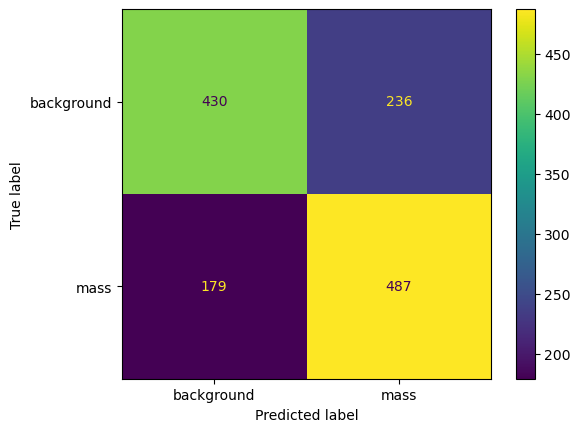

In [23]:
wrong_pred = []
with torch.no_grad():
    y_true = []
    y_pred = []
    correct = 0
    for idx, batch in enumerate(valid_loader):
        data = batch["pixel_values"].to(device)
        label = batch["labels"].type(torch.LongTensor).to(device)

        outputs = model1(data)

        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(label.tolist())
        y_pred.extend(predicted.tolist())
        correct += (predicted == label).sum()
        wrong_pred = np.concatenate(([idx.item() for idx in torch.nonzero(predicted != label)],wrong_pred), axis=0)
        
    print(f"Testing on {len(valid_loader.dataset)} images")
    print(f"accuracy:{accuracy_score(y_true,y_pred)}")
    print(f"precision:{precision_score(y_true,y_pred)}")
    print(f"recall:{recall_score(y_true,y_pred)}")
    print(f"f1-score:{f1_score(y_true,y_pred)}")

ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred),display_labels=["background","mass"]).plot()

## Ensemble method with soft-voting performance

Testing on 1332 images
accuracy:0.6674174174174174
precision:0.6723338485316847
recall:0.6531531531531531
f1-score:0.6626047220106625


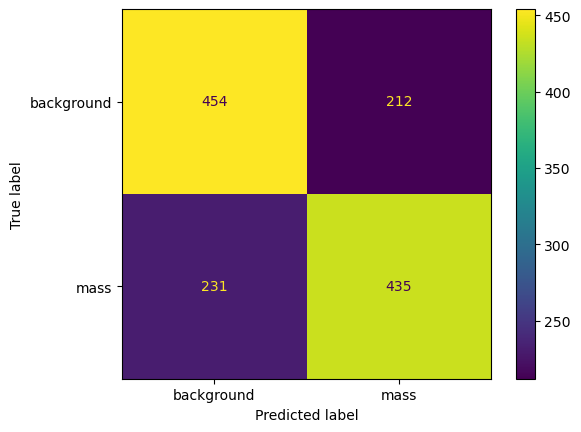

In [13]:
wrong_pred = []
with torch.no_grad():
    y_true = []
    y_pred = []
    correct = 0
    for idx, batch in enumerate(valid_loader):
        data = batch["pixel_values"].to(device)
        label = batch["labels"].type(torch.LongTensor).to(device)

        output1 = model1(data)
        output2 = model2(data)
#         _, predicted1 = torch.max(output1.data, 1)
#         _, predicted2 = torch.max(output2.data, 1)
#         all_predictions = torch.stack([predicted1, predicted2, predicted3], dim=1)
#         predicted_class, _ = torch.mode(all_predictions, dim=1)
        softmax = torch.nn.Softmax(dim=1)
        probs1 = softmax(output1)
        probs2 = softmax(output2)
        avg_probs = (output1 + output2) / 2
        _, predicted_class = avg_probs.max(dim=1)
        y_true.extend(label.tolist())
        y_pred.extend(predicted_class.tolist())
        correct += (predicted_class == label).sum()
        wrong_pred = np.concatenate(([idx.item() for idx in torch.nonzero(predicted_class != label)],wrong_pred), axis=0)
        
    print(f"Testing on {len(valid_loader.dataset)} images")
    print(f"accuracy:{accuracy_score(y_true,y_pred)}")
    print(f"precision:{precision_score(y_true,y_pred)}")
    print(f"recall:{recall_score(y_true,y_pred)}")
    print(f"f1-score:{f1_score(y_true,y_pred)}")

ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred),display_labels=["background","mass"]).plot()

## Ensemble method with hard voting performance

Testing on 1332 images
accuracy:0.6539039039039038
precision:0.6937618147448015
recall:0.551051051051051
f1-score:0.6142259414225941


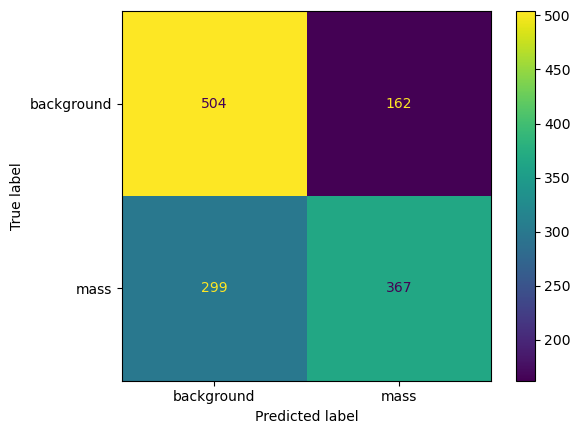

In [66]:
wrong_pred = []
with torch.no_grad():
    y_true = []
    y_pred = []
    correct = 0
    for idx, batch in enumerate(valid_loader):
        data = batch["pixel_values"].to(device)
        label = batch["labels"].type(torch.LongTensor).to(device)
        conf = batch["confidence"].to(device)
        output1 = model1(data)
        output2 = model2(data)
        output3 = (conf > 0.15).int()
        _, predicted1 = torch.max(output1.data, 1)
        _, predicted2 = torch.max(output2.data, 1)
        all_predictions = torch.stack([predicted1, predicted2, output3], dim=1)
        predicted_class, _ = torch.mode(all_predictions, dim=1)
        y_true.extend(label.tolist())
        y_pred.extend(predicted_class.tolist())
        correct += (predicted_class == label).sum()
        
    print(f"Testing on {len(valid_loader.dataset)} images")
    print(f"accuracy:{accuracy_score(y_true,y_pred)}")
    print(f"precision:{precision_score(y_true,y_pred)}")
    print(f"recall:{recall_score(y_true,y_pred)}")
    print(f"f1-score:{f1_score(y_true,y_pred)}")

ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred),display_labels=["background","mass"]).plot()

## Train the fusion network
Here we tried to train the fusion network on validation data to combine YOLO confidence score and CNN model's output.

However, the training accuracy could achieve at most 67%, so we didn't do the additional testing here

In [115]:
class FusionNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FusionNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
model = FusionNetwork(5,32,2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss() 

In [116]:
ACC=0
LOSS = 100
model2.eval()
for epoch in range(1000):
    model.train()
    print("Epoch:", epoch)
    train_loss = 0.0
    correct = 0
    for idx, batch in enumerate(tqdm(valid_loader)):
        data = batch["pixel_values"].to(device)
        label = batch["labels"].type(torch.LongTensor).to(device)
        confidence = batch["confidence"].to(device)
        confidence = confidence.unsqueeze(1)
        optimizer.zero_grad()
        with torch.no_grad():
            outputs1 = model1(data)
            outputs2 = model2(data)
        sigmoid_output1 = torch.sigmoid(outputs1)
        sigmoid_output2 = torch.sigmoid(outputs2)
        outputs_final = model(torch.cat((sigmoid_output1,sigmoid_output2, confidence), dim=1))
        loss = criterion(outputs_final, label)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs_final, 1)
        correct += (predicted == label).sum()
        train_loss += loss.item()
        
    avgloss = train_loss / len(valid_loader)
    acc = correct / len(valid_loader.dataset)
    checkpoint = {
                    "epoch":epoch,
                    "model_state":model.state_dict(),
                    "optim_state":optimizer.state_dict(),
                    "loss": avgloss
                }
    if avgloss < LOSS:
        checkpoint_best = {
            "epoch":epoch,
            "model_state":model.state_dict(),
            "optim_state":optimizer.state_dict(),
            "loss": avgloss
        }
        LOSS = avgloss
    print("Training")
    print(f"  avg loss:{avgloss}\n    accuracy:{acc*100}")

Epoch: 0


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6750848009472802
    accuracy:78.8021011352539
Epoch: 1


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.6224767721834636
    accuracy:98.57303619384766
Epoch: 2


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.5526531721864428
    accuracy:98.23506927490234
Epoch: 3


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.48770005504290265
    accuracy:98.27262878417969
Epoch: 4


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.4361369091840017
    accuracy:98.62936401367188
Epoch: 5


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.39992889974798473
    accuracy:98.62936401367188
Epoch: 6


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3756076040722075
    accuracy:98.7232437133789
Epoch: 7


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3621367656049274
    accuracy:98.64813995361328
Epoch: 8


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.35262172917524975
    accuracy:98.62936401367188
Epoch: 9


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3463115897916612
    accuracy:98.610595703125
Epoch: 10


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3430443420296624
    accuracy:98.53548431396484
Epoch: 11


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3410527954498927
    accuracy:98.3289566040039
Epoch: 12


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3384457209280559
    accuracy:98.53548431396484
Epoch: 13


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3374739424103782
    accuracy:98.44160461425781
Epoch: 14


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.33575832347075146
    accuracy:98.47915649414062
Epoch: 15


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3338592201471329
    accuracy:98.55426025390625
Epoch: 16


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3325148458991732
    accuracy:98.55426025390625
Epoch: 17


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3341685121967679
    accuracy:98.404052734375
Epoch: 18


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.32960960339932216
    accuracy:98.89222717285156
Epoch: 19


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3321590090081805
    accuracy:98.404052734375
Epoch: 20


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3307840043590182
    accuracy:98.6856918334961
Epoch: 21


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.33063759974070955
    accuracy:98.57303619384766
Epoch: 22


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.328823379107884
    accuracy:98.7044677734375
Epoch: 23


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3314626145930517
    accuracy:98.3101806640625
Epoch: 24


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3285103667350042
    accuracy:98.6856918334961
Epoch: 25


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3296133939708982
    accuracy:98.610595703125
Epoch: 26


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3266262206293288
    accuracy:98.87345123291016
Epoch: 27


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3295112358672278
    accuracy:98.51670837402344
Epoch: 28


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3297064517225538
    accuracy:98.5918197631836
Epoch: 29


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3284971955276671
    accuracy:98.62936401367188
Epoch: 30


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3286006322928837
    accuracy:98.7232437133789
Epoch: 31


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.33086128320012775
    accuracy:98.36650848388672
Epoch: 32


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3284083555142085
    accuracy:98.62936401367188
Epoch: 33


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.32927551226956503
    accuracy:98.44160461425781
Epoch: 34


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.327115162497475
    accuracy:98.7044677734375
Epoch: 35


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.32902769602480386
    accuracy:98.55426025390625
Epoch: 36


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.32676451404889423
    accuracy:98.81712341308594
Epoch: 37


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3287375867366791
    accuracy:98.4228286743164
Epoch: 38


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3285746290570214
    accuracy:98.610595703125
Epoch: 39


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3278684942495255
    accuracy:98.64813995361328
Epoch: 40


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3293638030687968
    accuracy:98.51670837402344
Epoch: 41


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3284351946342559
    accuracy:98.55426025390625
Epoch: 42


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3285146831046967
    accuracy:98.55426025390625
Epoch: 43


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.32698036162626176
    accuracy:98.81712341308594
Epoch: 44


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.32815242736112504
    accuracy:98.46038055419922
Epoch: 45


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3276064544916153
    accuracy:98.62936401367188
Epoch: 46


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3281088975213823
    accuracy:98.55426025390625
Epoch: 47


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.32741511222862063
    accuracy:98.57303619384766
Epoch: 48


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.32713263801165987
    accuracy:98.66691589355469
Epoch: 49


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.32654673428762526
    accuracy:98.7232437133789
Epoch: 50


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3292629945845831
    accuracy:98.47915649414062
Epoch: 51


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3302176168986729
    accuracy:98.25384521484375
Epoch: 52


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.326238914614632
    accuracy:98.81712341308594
Epoch: 53


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.32610746437595006
    accuracy:98.76079559326172
Epoch: 54


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.32872397488071803
    accuracy:98.51670837402344
Epoch: 55


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3257723259074347
    accuracy:98.81712341308594
Epoch: 56


  0%|          | 0/42 [00:00<?, ?it/s]

Training
  avg loss:0.3269662410020828
    accuracy:98.66691589355469
Epoch: 57


  0%|          | 0/42 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Concatenate CNN model with SVM
**step1**: We first extract features from two CNN models in training data

**step2**: Do the feature selection to reduce dimensionality

**step3**: Train the SVM model

**step4**: Extract features from validation data

**step5**: Reduce validation data dimensionality

**step6**: Showing the performance on validation data


In [12]:
extracted_features1 = 0
extracted_features2 = 0
def hook_1(module, input, output):
    # Store the output in a global variable (you can modify this based on your needs)
    global extracted_features1
    extracted_features1 = output
def hook_2(module, input, output):
    # Store the output in a global variable (you can modify this based on your needs)
    global extracted_features2
    extracted_features2 = output
model1.classifier[1].register_forward_hook(hook_1)
model2.avgpool.register_forward_hook(hook_2)

In [13]:
with torch.no_grad():
    for idx, batch in enumerate(train_loader):
        data = batch["pixel_values"].to(device)
        outputs1 = model1(data)
        outputs2 = model2(data)
        if idx == 0:
            y_train = batch["labels"]
            x_train1 = extracted_features1
            x_train2 = extracted_features2
            x_conf = batch["confidence"]
        else:
            y_train = torch.cat((y_train,batch["labels"]), 0)
            x_train1 = torch.cat((x_train1,extracted_features1), 0)
            x_train2 = torch.cat((x_train2,extracted_features2), 0)
            x_conf = torch.cat((x_conf,batch["confidence"]), 0)
x_train1 = x_train1.to('cpu').numpy()
y_train = y_train.to('cpu').numpy()
x_train2 = x_train2.to('cpu').numpy().reshape(5326, 2048)
x_conf = x_conf.numpy()
print(x_train1.shape,x_train2.shape,x_conf.shape)

(5326, 768) (5326, 2048) (5326,)


In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_1 = sel.fit_transform(x_train1)
removed_features1_indices = np.where(~sel.get_support())[0]
X_2 = sel.fit_transform(x_train2)
removed_features2_indices = np.where(~sel.get_support())[0]
print(X_1.shape,X_2.shape)
x_train_fusion = np.concatenate((X_1,X_2,x_conf.reshape(-1,1)),axis=1)

(5326, 40) (5326, 486)


In [17]:
clf = SVC(random_state=0, probability=True,kernel="linear")
clf.fit(x_train_fusion, y_train)

SVC(kernel='linear', probability=True, random_state=0)

In [18]:
with torch.no_grad():
    for idx, batch in enumerate(valid_loader):
        data = batch["pixel_values"].to(device)
        outputs1 = model1(data)
        outputs2 = model2(data)
        if idx == 0:
            y_test = batch["labels"]
            x_test1 = extracted_features1
            x_test2 = extracted_features2
            x_conf_test = batch["confidence"]
        else:
            y_test = torch.cat((y_test,batch["labels"]), 0)
            x_test1 = torch.cat((x_test1,extracted_features1), 0)
            x_test2 = torch.cat((x_test2,extracted_features2), 0)
            x_conf_test = torch.cat((x_conf_test,batch["confidence"]), 0)
x_test1 = x_test1.to('cpu').numpy()
y_test = y_test.to('cpu').numpy()
x_test2 = x_test2.to('cpu').numpy().reshape(1332, 2048)
x_conf_test = x_conf_test.numpy()
print(x_test1.shape,x_test2.shape,x_conf_test.shape)

(1332, 768) (1332, 2048) (1332,)


In [19]:
X1_without_columns = np.delete(x_test1, removed_features1_indices, axis=1)
X2_without_columns = np.delete(x_test2, removed_features2_indices, axis=1)
print(X1_without_columns.shape,X2_without_columns.shape)
x_test_fusion = np.concatenate((X1_without_columns,X2_without_columns,x_conf_test.reshape(-1,1)),axis=1)

(1332, 40) (1332, 486)


accuracy: 0.6478978978978979
Precision: 0.6476761619190404
recall: 0.6486486486486487
f1-score: 0.6481620405101275


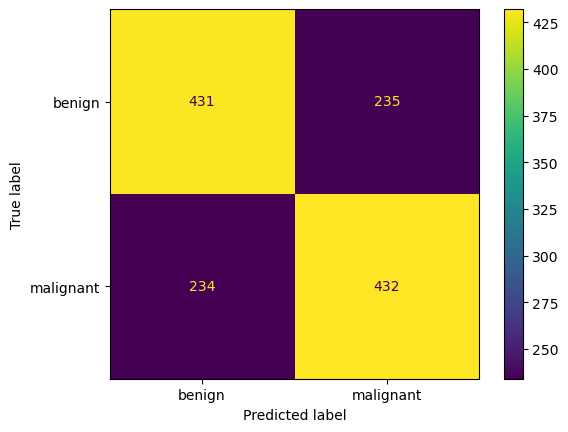

In [21]:
y_hat = clf.predict_proba(x_test_fusion)
print("accuracy:",accuracy_score(y_test, np.argmax(y_hat, axis=1)))
print("Precision:",precision_score(y_test, np.argmax(y_hat, axis=1)))
print("recall:",recall_score(y_test, np.argmax(y_hat, axis=1)))
print("f1-score:",f1_score(y_test,np.argmax(y_hat, axis=1)))
ConfusionMatrixDisplay(confusion_matrix(y_test,np.argmax(y_hat, axis=1)),display_labels=["benign","malignant"]).plot()

# Evaluate the performance of YOLO+CNN
- **predict_path** is the path for csv file of testing data generated by YOLO
- **clean_png_path** is the path of mammogram images in EMBED
- Here we read in the csv file and crop the ROI images from mammograms
- And using the convNeXt-tiny model to classify the ROI images
- **conf** is the YOLO confidence threshold 

In [91]:
# predict_path = os.path.join("D:","ml","CNN_labels")
predict_path = os.path.join("D:","ml","CNN_labels_005_exp49_test.csv")
test_csv = pd.read_csv(predict_path, dtype=str)
clean_png_path = "D:\\ml\\image\\png\\clean\\"
predict_bbox = []
original_bbox = []
predict_conf = []
predict_name = []
orginal_bbox = []
ground_bbox = []
correct_bbox = []
correct_name = []
picture = []
background = 0
mass = 0
test_transform = Compose(
    [
        ToPILImage(),
        Resize((224,224)),
        ToTensor(),
        normalize,
    ]
)
with open("new_table.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        filename = row[0]
        result_list = ast.literal_eval(row[1])
        ground = []
        for i,ROI in enumerate(result_list):
            x1,y1,x2,y2 = ROI
            ground.append((x1,y1,x2,y2))
        ground_bbox.append(ground)
        ground_name.append(filename)
        
for i,row in enumerate(test_csv.iloc):
    box = []
    original_box = []
    conf_list = []
    image = cv2.imread(clean_png_path+row['name']+".png")
    for roi in ast.literal_eval(row["ROI"]):
        y1,x1,y2,x2,conf = float(roi[0]),float(roi[1]),float(roi[2]),float(roi[3]),float(roi[4])
        if conf > 0.05:
            original_box.append((x1,y1,x2,y2))
            data = test_transform(image[int(y1):int(y2), int(x1):int(x2)])
            data = data.reshape((1,) + data.shape)
            with torch.no_grad():
                data = data.to(device)
                outputs = model1(data)
                softmax_output = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs.data, 1)
                if predicted[0].item() == 1:
                    mass += 1
                    box.append((x1,y1,x2,y2))
                else:
                    background+=1
    original_bbox.append(original_box)
    predict_bbox.append(box)
    predict_name.append(row['name'])
    predict_conf.append(conf_list)
    index = ground_name.index(row['name']+".png")
    correct_bbox.append(ground_bbox[index])
    correct_name.append(row['name']+".png")

print("mass:",mass)
print("background:",background)

mass: 946
background: 1270


## The performance between YOLO and YOLO+CNN

In [92]:
total_guess = 0
total_ground = 0
correct = 0
for i,(gd_box,pre_box) in enumerate(zip(correct_bbox,original_bbox)):
    gd_index, pred_index, iou, label = match_bboxes(np.array(gd_box),np.array(pre_box),0.1)
    correct += np.sum(label)
    total_guess += len(label)
    total_ground += len(gd_box)
    
precision_o = correct/total_guess
recall_o = correct/total_ground
print("YOLO performance:")
print("Precision:",precision_o)
print("Recall:",recall_o)
print("f1-score:",2*precision_o*recall_o/(precision_o+recall_o))

total_guess = 0
total_ground = 0
correct = 0
for i,(gd_box,pre_box) in enumerate(zip(correct_bbox,predict_bbox)):
    gd_index, pred_index, iou, label = match_bboxes(np.array(gd_box),np.array(pre_box),0.1)
    correct += np.sum(label)
    total_guess += len(label)
    total_ground += len(gd_box)

precision = correct/total_guess
recall = correct/total_ground
print("YOLO+CNN performance:")
print("Precision:",precision)
print("Recall:",recall)
print("f1-score:",2*precision*recall/(precision+recall))
print("ratio:",(precision-precision_o)/(recall_o-recall))

YOLO performance:
Precision: 0.20351985559566788
Recall: 0.710236220472441
f1-score: 0.3163802174675553
After concatenation:
Precision: 0.33403805496828753
Recall: 0.49763779527559054
f1-score: 0.3997469955724225
ratio: 0.6139189377897295
